Setup

In [2]:
!pip install --quiet transformers datasets matplotlib wandb pandas==2.2.2

In [3]:
import os

# hugging face
from huggingface_hub import login
hf_token = os.environ.get('HF_TOKEN')
login(token=hf_token)

# wandb
import wandb
wandb_api_key = os.environ.get('WANDB')
wandb.login(key=wandb_api_key)

# google colab
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/AML Project')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: meiligupta (mwgupta). Use `wandb login --relogin` to force relogin


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data

In [17]:
dataset_name = 'books' #@param ["gov_report", "pub_med", "books"]

In [21]:
from datasets import load_dataset

if dataset_name == 'gov_report':
    dataset = load_dataset('ccdv/govreport-summarization')
elif dataset_name == 'pub_med':
    # Load the PubMed summarization dataset
    dataset = load_dataset('scientific_papers', 'pubmed')

    # remove section_names, and rename article and abstract to report and summary respectively to align with naming convention for gov report
    dataset = dataset.remove_columns(['section_names'])
    dataset = dataset.rename_column('article', 'report')
    dataset = dataset.rename_column('abstract', 'summary')
elif dataset_name == 'books':
    dataset = load_dataset("emozilla/pg19")
    dataset = dataset.rename_column('text', 'report')
    dataset = dataset.rename_column('short_book_title', 'summary')

print(dataset)

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['summary', 'publication_date', 'url', 'report'],
        num_rows: 28602
    })
    validation: Dataset({
        features: ['summary', 'publication_date', 'url', 'report'],
        num_rows: 50
    })
    test: Dataset({
        features: ['summary', 'publication_date', 'url', 'report'],
        num_rows: 100
    })
})


Load model

In [6]:
model_name = 't5' #@param ["ttt", "t5"]

if model_name == 'ttt':
  from ttt import TTTForCausalLM, TTTConfig, TTT_STANDARD_CONFIGS
  from transformers import AutoTokenizer

  tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')
  if tokenizer.pad_token is None:
      tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  config = TTTConfig(**TTT_STANDARD_CONFIGS['125m'])
  model = TTTForCausalLM(config)

elif model_name == 't5':
  from transformers import T5Tokenizer, T5ForConditionalGeneration
  model_id = "t5-base"
  tokenizer = T5Tokenizer.from_pretrained(model_id)
  model = T5ForConditionalGeneration.from_pretrained(model_id)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Lora

In [ ]:
lora = True #@param {type:"boolean"}

if lora:
  # print total number of trainable parameters before
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"# trainable parameters: {trainable_params}")

  # add lora
  from peft import LoraConfig, get_peft_model
  lora_config = LoraConfig(
      r=16,
      lora_alpha=32,
      target_modules=["q_proj", "v_proj"],
      lora_dropout=0.1,
      bias="none",
      task_type="CAUSAL_LM"
  )

  model = get_peft_model(model, lora_config)

  # print total number of trainable parameters before
  trainable_params_after = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"# trainable parameters (with LORA): {trainable_params_after}")

  print(f"Training {round(trainable_params_after / trainable_params * 100, 2)}% of total parameters")

Tokenize

In [22]:
from torch.utils.data import DataLoader
import torch

# Tokenization function
def tokenize_function(examples):
    # Tokenize 'report' as input and 'summary' as labels
    inputs = tokenizer(examples["report"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    labels = tokenizer(examples["summary"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    # Replace padding token id with -100 to ignore them in the loss calculation
    labels[labels == tokenizer.pad_token_id] = -100

    # Ensure input IDs are within the valid range of the vocabulary size
    vocab_size = tokenizer.vocab_size
    inputs["input_ids"] = inputs["input_ids"].clamp(min=0, max=vocab_size - 1)
    labels["input_ids"] = labels["input_ids"].clamp(min=0, max=vocab_size - 1)

    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": labels["input_ids"]}

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/28602 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
# save tokenized
import numpy as np
save_path = f'./{model_name}_model/{dataset_name}'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, "train.npy"), tokenized_datasets["train"])
np.save(os.path.join(save_path, "val.npy"), tokenized_datasets["validation"])
np.save(os.path.join(save_path, "test.npy"), tokenized_datasets["test"])
np.save(os.path.join(save_path, "input_ids.npy"), tokenized_datasets["train"]["input_ids"])
np.save(os.path.join(save_path, "attention_mask.npy"), tokenized_datasets["train"]["attention_mask"])
np.save(os.path.join(save_path, "labels.npy"), tokenized_datasets["train"]["labels"])

In [ ]:
# load tokenized
import os
import numpy as np
from datasets import Dataset

# Paths and setup
save_path = f'./{model_name}_model/{dataset_name}'
tokenized_datasets = {}

# Load tokenized datasets and convert to Hugging Face Dataset format
for split in ["train", "val", "test"]:
    data = np.load(os.path.join(save_path, f"{split}.npy"), allow_pickle=True)

    # Convert numpy array to a list of dictionaries if necessary
    if isinstance(data, np.ndarray):
        data = data.tolist()

    # Convert to Hugging Face Dataset
    tokenized_datasets[split] = Dataset.from_list(data)

# Example usage of `.select` method on the train dataset
selected_data = tokenized_datasets["train"].select(range(100))  # Select the first 100 samples

# Output for verification
print(f"Loaded datasets: {list(tokenized_datasets.keys())}")
print(f"Sample data from train: {tokenized_datasets['train'][0]}")

In [ ]:
# just a couple more things
model_before = model

if model_name == 'ttt':
  model.train()
  model.resize_token_embeddings(len(tokenizer))

Train

In [ ]:
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Use DataCollatorForLanguageModeling if you are working with text data
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,  # Make sure to define or import the tokenizer if needed
    mlm=False  # Set to True if using masked language modeling
)

# Set training arguments
training_args = TrainingArguments(
    output_dir=f'./{model_name}_model/{dataset_name}',
    overwrite_output_dir=True,
    num_train_epochs=1,
    fp16=True, # to try and reduce GPU RAM
    per_device_train_batch_size=1,
    save_steps=10_000,
    save_total_limit=2,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train'].select(range(10000)), # added the .select() for PubMed because training on all 120k examples would take 13 hours
)

# Start training
trainer.train()

In [ ]:
# Save the fine-tuned model
model.save_pretrained(f'./{model_name}_model/{dataset_name}')
tokenizer.save_pretrained(f'./{model_name}_model/{dataset_name}')

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('./t5_model/pub_med/tokenizer_config.json',
 './t5_model/pub_med/special_tokens_map.json',
 './t5_model/pub_med/spiece.model',
 './t5_model/pub_med/added_tokens.json',
 './t5_model/pub_med/tokenizer.json')

Training Loss Graph

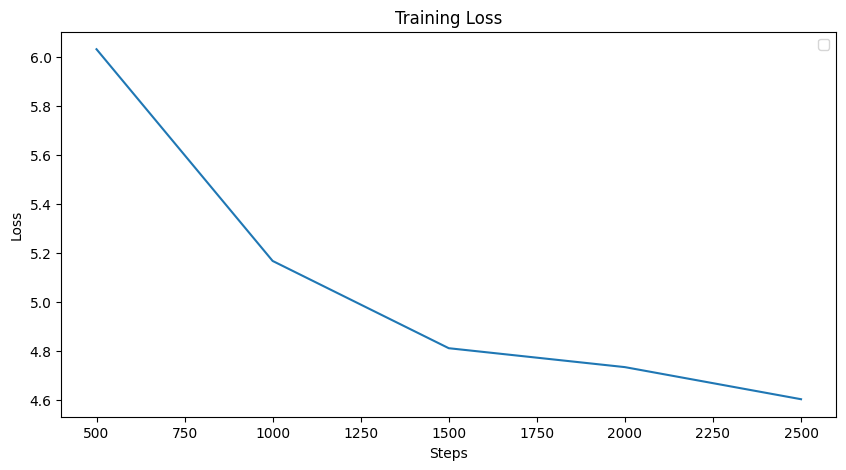

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the training logs using json module first to inspect its structure
with open(f'./{model_name}_model/{dataset_name}/checkpoint-2500/trainer_state.json', 'r') as file:
    logs = json.load(file)

# Extract loss values
train_loss = [entry.get('loss') for entry in logs['log_history']]
steps = [entry.get('step') for entry in logs['log_history']]

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

Perplexity

In [ ]:
import torch
from tqdm import tqdm
import numpy as np

def calculate_perplexity(model, dataset, tokenizer):
    model.eval()
    total_loss = 0
    for batch in tqdm(dataset):
        inputs = tokenizer(batch['report'], return_tensors='pt', truncation=True, padding=True)
        inputs = {key: val.to(model.device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            total_loss += outputs.loss.item()

    avg_loss = total_loss / len(dataset)
    perplexity = np.exp(avg_loss)

    return perplexity, outputs

eval_subset = tokenized_datasets['val'].select(range(100))

In [ ]:
# Calculate perplexity before fine-tuning
perplexity_before, outputs_before = calculate_perplexity(model_before, eval_subset, tokenizer)
print(f'Perplexity before fine-tuning: {perplexity_before}')

In [ ]:
# Calculate perplexity after fine-tuning
perplexity_after, rouge_after = calculate_perplexity(model, eval_subset, tokenizer)
print(f'Perplexity after fine-tuning: {perplexity_after}')

Specific examples

In [31]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Assume `dataset` is your dataset containing articles
def generate_example(model, article):
    model.eval()
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=150,
            num_beams=5,
            early_stopping=True
        )

    return tokenizer.decode(output[0], skip_special_tokens=True)

# Fetch the first article from the dataset
gt_summary = dataset['train'][0]['summary']
first_article = dataset['train'][0]['report']
print("Ground Truth Summary:")
print(gt_summary)

print("\nGenerated Summary (Baseline):")
generated_summary = generate_example(model_before, first_article)
print(generated_summary)

Ground Truth Summary:
 background : the present study was carried out to assess the effects of community nutrition intervention based on advocacy approach on malnutrition status among school - aged children in shiraz , iran.materials and methods : this case - control nutritional intervention has been done between 2008 and 2009 on 2897 primary and secondary school boys and girls ( 7 - 13 years old ) based on advocacy approach in shiraz , iran . 
 the project provided nutritious snacks in public schools over a 2-year period along with advocacy oriented actions in order to implement and promote nutritional intervention . for evaluation of effectiveness of the intervention growth monitoring indices of pre- and post - intervention were statistically compared.results:the frequency of subjects with body mass index lower than 5% decreased significantly after intervention among girls ( p = 0.02 ) . 
 however , there were no significant changes among boys or total population . 
 the mean of all 

In [33]:
!pip install rouge

In [35]:
# calculate rouge between baseline_summary and
generated_summary = "a recent systematic analysis showed that in 2011 , 314 ( 296 - 331 ) million children younger than 5 years were mildly , moderately or severely stunted . in iran a national free food program ( nffp ) is implemented in elementary schools of deprived areas to cover all poor students . however , many students in deprived areas are not actually poor and can afford food ."

from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(generated_summary, baseline_summary)
print(scores)

[{'rouge-1': {'r': 0.14473684210526316, 'p': 0.41509433962264153, 'f': 0.21463414250755508}, 'rouge-2': {'r': 0.01327433628318584, 'p': 0.046875, 'f': 0.020689651732699738}, 'rouge-l': {'r': 0.125, 'p': 0.3584905660377358, 'f': 0.18536584982462828}}]
